In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from sklearn.preprocessing import MinMaxScaler
from hyperopt import hp, fmin, tpe, space_eval, STATUS_OK, Trials
from keras import backend as K
print("Image format : ", K.image_data_format())

Image format :  channels_last


# Overview

## Data and pre-processing
- Started with Kuzushiji dataset available in a convenient format.
- Train and test sets had similar class distributions and were **balanced**.
- Scaled features with SciPy's `MinMaxScaler`.
- Used `keras.utils.to_categorical` to one hot encode the labels.

## Baseline
- Feedforward NN with 1 hidden layer, 32 ReLU units.
- Accuracy: train = 0.77, test = 0.65

## Approach
- **Convolution** neural network.
- Used **batchnorm** greatly which greatly sped up learning.
- `hyperopt` for **hyperparameter optimization** to identify best kernel size, pool size and stride.
- Accuracy: train = 0.99, test = 0.94 --> overfitting

## Fine tune
- Added another conv-pool-batchnorm layer to increase number of features.
- Accuracy: train = **0.99**, test = **0.95**

# EDA
Start with loading the dataset and looking at the shape and size of the inputs and outputs.

In [5]:
Xtrain = np.load("../input/k49-train-imgs.npz")['arr_0']
ytrain = np.load("../input/k49-train-labels.npz")['arr_0']
Xtest = np.load("../input/k49-test-imgs.npz")['arr_0']
ytest = np.load("../input/k49-test-labels.npz")['arr_0']
Xtrain.shape, ytrain.shape[0], Xtest.shape, ytest.shape

((232365, 28, 28), 232365, (38547, 28, 28), (38547,))

## Frequency of class labels
How frequent is each class label in the train and test datasets?

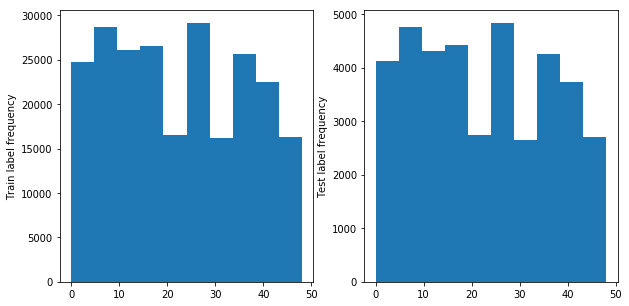

In [6]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.hist(ytrain); plt.ylabel("Train label frequency");
plt.subplot(122)
plt.hist(ytest); plt.ylabel("Test label frequency");

Train and test samples have very similar relative frequencies. 

The labels are direct categorical integers too, and there is only one dimension presently. This will need to be converted to one hot encoding for prediction. Now what is the range of each feature?

In [7]:
n = Xtrain.shape[0]
t = Xtrain.reshape(n, -1)
# If these asserts don't fail, each feature ranges from 0 to 255.
assert (np.max(t, axis=0) == 255).all()
assert (np.min(t, axis=0) == 0).all()

 Each feature ranges from 0 to 255. Moving forward, start with preprocessing the data for Keras using a function.

1. MinMax scaler from scikit-learn (scales each feature independently to the maximum and minimum for that feature). This is sufficient since each feature varies from 0 to 255.
2. Since keras uses `channels_last` for images (as printed above), did not write code for what to do in case of `channels_first`.
3. Use `keras.utils.to_categorical` to get the one hot encoded train and test labels.

In [19]:
def get_data():
    Xtrain = np.load("../input/k49-train-imgs.npz")['arr_0']
    ytrain = np.load("../input/k49-train-labels.npz")['arr_0']
    Xtest = np.load("../input/k49-test-imgs.npz")['arr_0']
    ytest = np.load("../input/k49-test-labels.npz")['arr_0']

    train_one_hot_labels = keras.utils.to_categorical(ytrain, num_classes=49)
    test_one_hot_labels = keras.utils.to_categorical(ytest, num_classes=49)
    n_train = ytrain.shape[0]
    n_test = ytest.shape[0]
    npix = Xtrain.shape[1] # Number of pixels

    Xtrain1 = Xtrain.reshape(n_train, -1)
    Xtest1 = Xtest.reshape(n_test, -1)
    scaler = MinMaxScaler()
    Xtrain1 = scaler.fit_transform(Xtrain1).astype('float32')
    Xtest1 = scaler.fit_transform(Xtest1).astype('float32')
    if K.image_data_format() == 'channels_last':
        Xtrain2d = Xtrain.reshape(n_train, npix, npix, 1).astype('float32')/255
        Xtest2d = Xtest.reshape(n_test, npix, npix, 1).astype('float32')/255
        input_shape = (npix, npix, 1)
    else:
        print("Images not resized")
        # Did not write this code as keras was already using `channels_last`
    return (Xtrain2d, train_one_hot_labels, Xtest2d, test_one_hot_labels, input_shape)

def plot_history(history):
    # Plot the accuracy and loss for train and test sets.
    
    # Plot training & validation accuracy values
    plt.figure(figsize=(12,5))
    plt.subplot(121)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    print(f"Final accuracy: Train = {history.history['acc'][-1]:.3f}, Test = {history.history['val_acc'][-1]:.3f}")

    # Plot training & validation loss values
    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    print(f"Final loss: Train = {history.history['loss'][-1]:.3f}, Test = {history.history['val_loss'][-1]:.3f}")
    
    plt.show()

In [9]:
Xtrain, ytrain, Xtest, ytest, input_shape = get_data()
ntrain, ntest = Xtrain.shape[0], Xtest.shape[0]
Xtrain1d = Xtrain.reshape(ntrain,-1)
Xtest1d = Xtest.reshape(ntest,-1)

# Simple model

We start with a one layer dense feed forawrd network to establish a benchmark. Architecture will be:

1. 1 hidden layer with 32 neurons, ReLU activation.

In [23]:
model = Sequential([
    Dense(32, input_shape=(784,)),
    Activation('relu'),
    Dense(49),
    Activation('softmax'),
])

# For a multi-class classification problem
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(Xtrain1d, ytrain, epochs=25, batch_size=256, validation_data = (Xtest1d, ytest))

Train on 232365 samples, validate on 38547 samples
Epoch 1/25
232365/232365 [==============================] - 6s 24us/step - loss: 1.7274 - acc: 0.5801 - val_loss: 1.8855 - val_acc: 0.5504
Epoch 2/25
232365/232365 [==============================] - 4s 18us/step - loss: 1.2791 - acc: 0.6809 - val_loss: 1.7416 - val_acc: 0.5865
Epoch 3/25
232365/232365 [==============================] - 4s 17us/step - loss: 1.1846 - acc: 0.7023 - val_loss: 1.7021 - val_acc: 0.5956
Epoch 4/25
232365/232365 [==============================] - 4s 17us/step - loss: 1.1305 - acc: 0.7144 - val_loss: 1.6532 - val_acc: 0.6089
Epoch 5/25
232365/232365 [==============================] - 4s 17us/step - loss: 1.0932 - acc: 0.7234 - val_loss: 1.6166 - val_acc: 0.6162
Epoch 6/25
232365/232365 [==============================] - 4s 17us/step - loss: 1.0636 - acc: 0.7298 - val_loss: 1.5890 - val_acc: 0.6222
Epoch 7/25
232365/232365 [==============================] - 4s 17us/step - loss: 1.0388 - acc: 0.7359 - val_loss: 1

Final accuracy: Train = 0.771, Test = 0.657
Final loss: Train = 0.880, Test = 1.442


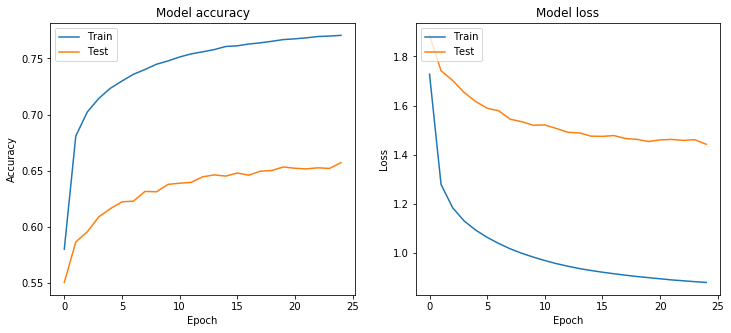

In [24]:
plot_history(history)

We have 77% accuracy on the train and 65% on the test data to begin with. This is without accounting for the spatial data (no convolution).

# Convolution + batchnorm with hyper-opt

Start with a convolution network and use hyper-opt to find the best kernel size, pool size and stride size.

1. Kernel size : (2,3,4)
2. Pool size : (2,3,4)
3. Stride size : (1,2)

## Architecture
Conv32-Conv64-Pool-BatchNorm-Dropout(25%)-Flatten-BatchNorm-Dense128(ReLU)-Dense49(softmax)

In [ ]:
def objective(args):
    """For use in the initial hyper-parameter optimization.
    """
    
    # Assign arugments. If same size in both directions, it is enough to specify one integer.
    kernelsize = args['ksize'] #(3, 3)
    poolsize = args['psize'] #(2, 2)
    stridesize = args['ssize']
    
    # Build model
    model3 = Sequential()
    model3.add(Conv2D(32, kernel_size=kernelsize,
                      strides=stridesize,
                      activation='relu',
                      input_shape=input_shape))
    model3.add(Conv2D(64, kernel_size=kernelsize, strides=stridesize, activation='relu'))
    model3.add(MaxPooling2D(pool_size=poolsize))
    model3.add(BatchNormalization())
    model3.add(Dropout(0.25))
    model3.add(Flatten())
    model3.add(BatchNormalization())
    model3.add(Dense(128, activation='relu'))
    model3.add(BatchNormalization())
    #         model3.add(Dropout(0.5))
    model3.add(Dense(49, activation='softmax'))
    model3.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    # Train
    history3 = model3.fit(Xtrain, ytrain, epochs=25, batch_size=256, validation_data = (Xtest, ytest), verbose=0)
    return_object = {}
    return_object["status"] = STATUS_OK
    return_object["loss"] = history3.history['loss'][0]
    return_object["deets"] = {"loss":history3.history['loss'][0], 
                             "val_loss":history3.history['val_loss'][0],
                             "acc":history3.history['acc'][0],
                             "val_acc":history3.history['val_acc'][0],
                             "args":args,
                             "model":model3}
    return return_object

In [ ]:
space = hp.choice('a', [{'ksize':hp.choice('ksize_val', [2,3,4]),
                         'psize':hp.choice('psize_val', [2,3,4]),
                         'ssize':hp.choice('stridesize_val', [1,2])}])

trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=10, trials=trials)

In [ ]:
print(best)
trials.results

In [ ]:
best_model_ind = np.argmin(trials.losses())

### Conclusion

From the hyperparameter optimization and early stopping above, we see that a kernel size of 4, maxpool of 2 and stride size of 1 provide the best fit. 

## Closer look
Re-run this model for longer and look at the accuracy and loss over the training period.

In [10]:
# Define best fit parameters
kernelsize = 4
poolsize = 2
stridesize = 1

In [12]:
# Build model
model3 = Sequential()
model3.add(Conv2D(32, kernel_size=kernelsize,
                  strides=stridesize,
                  activation='relu',
                  input_shape=input_shape))
model3.add(Conv2D(64, kernel_size=kernelsize, strides=stridesize, activation='relu'))
model3.add(MaxPooling2D(pool_size=poolsize))
model3.add(BatchNormalization())
model3.add(Dropout(0.25))
model3.add(Flatten())
model3.add(BatchNormalization())
model3.add(Dense(128, activation='relu'))
model3.add(BatchNormalization())
#         model3.add(Dropout(0.5))
model3.add(Dense(49, activation='softmax'))
model3.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
# Train
history3 = model3.fit(Xtrain, ytrain, epochs=50, batch_size=256, validation_data = (Xtest, ytest))


Train on 232365 samples, validate on 38547 samples
Epoch 1/50
232365/232365 [==============================] - 16s 69us/step - loss: 0.4186 - acc: 0.8950 - val_loss: 0.3826 - val_acc: 0.9004
Epoch 2/50
232365/232365 [==============================] - 15s 63us/step - loss: 0.1618 - acc: 0.9562 - val_loss: 0.3234 - val_acc: 0.9162
Epoch 3/50
232365/232365 [==============================] - 15s 63us/step - loss: 0.1096 - acc: 0.9699 - val_loss: 0.2892 - val_acc: 0.9281
Epoch 4/50
232365/232365 [==============================] - 15s 65us/step - loss: 0.0811 - acc: 0.9774 - val_loss: 0.3089 - val_acc: 0.9265
Epoch 5/50
232365/232365 [==============================] - 15s 63us/step - loss: 0.0628 - acc: 0.9824 - val_loss: 0.3041 - val_acc: 0.9278
Epoch 6/50
232365/232365 [==============================] - 15s 63us/step - loss: 0.0510 - acc: 0.9853 - val_loss: 0.3081 - val_acc: 0.9307
Epoch 7/50
232365/232365 [==============================] - 15s 63us/step - loss: 0.0409 - acc: 0.9882 - val_

Final accuracy: Train = 0.999, Test = 0.941
Final loss: Train = 0.005, Test = 0.361


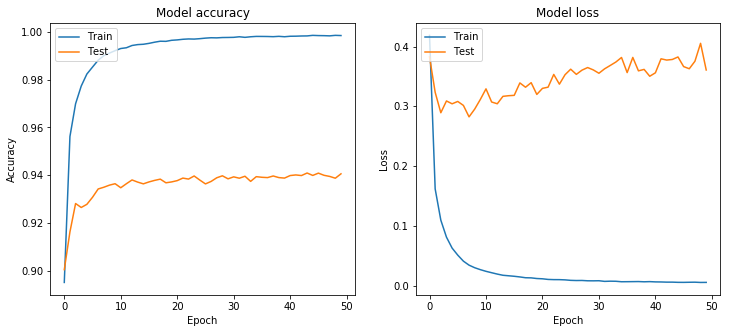

In [20]:
plot_history(history3)

### Observation : overfitting

These are the hallmarks of overfitting. The training loss decreases continuously, and the testing loss first decreases and then increases. The training accuracy is over 0.99, but the testing accuracy does not dip by much and hovers around the 0.94 mark. 

This suggests that increasing number of neurons in the dense layer will not greatly improve classifcation. Two ways forward are:

1. Add some regularization.
2. Add more featuers by means of more convolution layers.

#### 1. Add regularization
Increase dropout from 0.25 to 0.5 to increase regularization.

In [ ]:
model4 = Sequential()
model4.add(Conv2D(32, kernel_size=kernelsize,
                  strides=stridesize,
                  activation='relu',
                  input_shape=input_shape))
model4.add(Conv2D(64, kernel_size=kernelsize, strides=stridesize, activation='relu'))
model4.add(MaxPooling2D(pool_size=poolsize))
model4.add(BatchNormalization())
model4.add(Dropout(0.5)) # Changed from 0.25 previously
model4.add(Flatten())
model4.add(BatchNormalization())
model4.add(Dense(128, activation='relu'))
model4.add(BatchNormalization())
model4.add(Dense(49, activation='softmax'))
model4.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
# Train
history4 = model4.fit(Xtrain, ytrain, epochs=50, batch_size=256, validation_data = (Xtest, ytest), verbose=1)

#### Conclusion
Increasing dropout from 0.25 to 0.5 did not work. 

#### 2. More convolution
Add another convolution layer and see if that helps. The new architecture is:

Conv32-Conv64-Pool-BatchNorm-**Conv64-Pool-BatchNorm**-Dropout(25%)-Flatten-BatchNorm-Dense128(ReLU)-Dense49(softmax)

with the addition in **bold**.

In [21]:
model4 = Sequential()
model4.add(Conv2D(32, kernel_size=kernelsize,
                  strides=stridesize,
                  activation='relu',
                  input_shape=input_shape))
model4.add(Conv2D(64, kernel_size=kernelsize, strides=stridesize, activation='relu'))
model4.add(MaxPooling2D(pool_size=poolsize))
model4.add(BatchNormalization())
model4.add(Conv2D(64, kernel_size=kernelsize, strides=stridesize, activation='relu'))
model4.add(MaxPooling2D(pool_size=poolsize))
model4.add(BatchNormalization())
model4.add(Dropout(0.25))
model4.add(Flatten())
model4.add(BatchNormalization())
model4.add(Dense(128, activation='relu'))
model4.add(BatchNormalization())
model4.add(Dense(49, activation='softmax'))
model4.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
# Train
history4 = model4.fit(Xtrain, ytrain, epochs=50, batch_size=256, validation_data = (Xtest, ytest), verbose=1)

Train on 232365 samples, validate on 38547 samples
Epoch 1/50
232365/232365 [==============================] - 18s 77us/step - loss: 0.5190 - acc: 0.8684 - val_loss: 0.4116 - val_acc: 0.8931
Epoch 2/50
232365/232365 [==============================] - 16s 70us/step - loss: 0.1921 - acc: 0.9473 - val_loss: 0.3029 - val_acc: 0.9216
Epoch 3/50
232365/232365 [==============================] - 16s 69us/step - loss: 0.1442 - acc: 0.9599 - val_loss: 0.2365 - val_acc: 0.9386
Epoch 4/50
232365/232365 [==============================] - 16s 70us/step - loss: 0.1189 - acc: 0.9668 - val_loss: 0.2248 - val_acc: 0.9422
Epoch 5/50
232365/232365 [==============================] - 16s 69us/step - loss: 0.1027 - acc: 0.9710 - val_loss: 0.2163 - val_acc: 0.9457
Epoch 6/50
232365/232365 [==============================] - 16s 70us/step - loss: 0.0903 - acc: 0.9741 - val_loss: 0.2097 - val_acc: 0.9466
Epoch 7/50
232365/232365 [==============================] - 16s 70us/step - loss: 0.0822 - acc: 0.9763 - val_

Final accuracy: Train = 0.994, Test = 0.954
Final loss: Train = 0.018, Test = 0.245


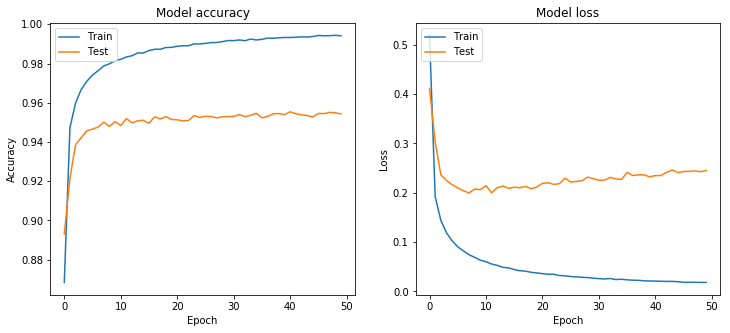

In [22]:
plot_history(history4)

#### Conclusion
Adding a convolution layer improved test accuracy from 0.94 to 0.95

# Final conclusion

The final model is:

Conv32-Conv64-Pool-BatchNorm-Conv64-Pool-BatchNorm-Dropout(25%)-Flatten-BatchNorm-Dense128(ReLU)-Dense49(softmax)

It gives training accuracy = **0.99** and testing accruacy of **0.95**.

While the loss function does indicate some overfitting, accuracy seems pretty stable or even slightly increasing.